# Aim of this notebook

* To construct the singular curve of universal type to finalize the solution of the optimal control problem

# Preamble

In [1]:
from sympy import *
init_printing(use_latex='mathjax')

# Plotting
%matplotlib inline
## Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
## Import modules for plotting and data analysis
import matplotlib.pyplot as plt
from matplotlib import gridspec,rc,colors
import matplotlib.ticker as plticker
## Parameters for seaborn plots
import seaborn as sns
sns.set(style='white',font_scale=1.25,
        rc={"xtick.major.size": 6, "ytick.major.size": 6,
            'text.usetex': False, 'font.family': 'serif', 'font.serif': ['Times']})

import pandas as pd
pd.set_option('mode.chained_assignment',None)

import numpy as np
from scipy.optimize import fsolve, root
from scipy.integrate import ode
backend = 'dopri5'
import warnings

# Timer
import time

from copy import deepcopy

from itertools import cycle
palette_size = 10;
clrs = sns.color_palette("Reds",palette_size)
iclrs = cycle(clrs) # iterated colors

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Parameter values

* Birth rate and const of downregulation are defined below in order to fit some experim. data

In [2]:
d = .13 # death rate
c = .02 # cost of resistance
α = .3 # low equilibrium point at expression of the main pathway (high equilibrium is at one)
θ = .45 # threshold value for the expression of the main pathway
κ = 40 # robustness parameter
L = .2 # parameter used to model the effect of treatment (see the line below)

* Symbolic variables - the list insludes μ & μbar, because they will be varied later

In [3]:
σ, φ0, φ, x, μ, μbar = symbols('sigma, phi0, phi, x, mu, mubar')

* Main functions

In [4]:
A = 1-σ*(1-θ)*(1-L)
Θ = θ+σ*(1-θ)*L
Eminus = (α*A-Θ)**2/2
ΔE = A*(1-α)*((1+α)*A/2-Θ)
ΔEf = lambdify(σ,ΔE)

* Birth rate and cost of downregulation

In [5]:
b = (0.1*(exp(κ*(ΔEf(1)))+1)-0.14*(exp(κ*ΔEf(0))+1))/(exp(κ*ΔEf(1))-exp(κ*ΔEf(0))) # birth rate
χ = 1-(0.14*(exp(κ*ΔEf(0))+1)-b*exp(κ*ΔEf(0)))/b
b, χ

(0.140154784911281, 0.299759386875464)

* Hamiltonian *H* and a part of it ρ that includes the control variable σ

In [6]:
h = b*(χ/(exp(κ*ΔE)+1)*(1-x)+c*x)
H = -φ0 + φ*(b*(χ/(exp(κ*ΔE)+1)-c)*x*(1-x)+μ*(1-x)/(exp(κ*ΔE)+1)-μbar*exp(-κ*Eminus)*x) + h
ρ = (φ*(b*χ*x+μ)+b*χ)/(exp(κ*ΔE)+1)*(1-x)-φ*μbar*exp(-κ*Eminus)*x
H, ρ

⎛  ⎛                                                                       2  
⎜  ⎜                μ⋅(-x + 1)                        -20⋅(-0.242⋅σ - 0.15)   
⎜φ⋅⎜───────────────────────────────────────── - μ̅⋅x⋅ℯ                       +
⎜  ⎜ 40⋅(-0.396⋅σ + 0.2)⋅(-0.308⋅σ + 0.7)                                     
⎝  ⎝ℯ                                     + 1                                 

                                                                              
   ⎛                                   0.042012712392668            ⎞         
 x⋅⎜-0.00280309569822561 + ─────────────────────────────────────────⎟⋅(-x + 1)
   ⎜                        40⋅(-0.396⋅σ + 0.2)⋅(-0.308⋅σ + 0.7)    ⎟         
   ⎝                       ℯ                                     + 1⎠         

⎞                                                                             
⎟                                        0.042012712392668⋅(-x + 1)           
⎟ - φ₀ + 0.00280309569822561⋅x + ─────────────────

* Same but for no treatment (σ = 0)

In [7]:
h0 = h.subs(σ,0)
H0 = H.subs(σ,0)
ρ0 = ρ.subs(σ,0)
H0, ρ0

(φ⋅(0.00368423989943599⋅μ⋅(-x + 1) - 0.637628151621773⋅μ̅⋅x - 0.00264831078694
502⋅x⋅(-x + 1)) - φ₀ + 0.00264831078694502⋅x + 0.000154784911280596, -0.637628
151621773⋅μ̅⋅φ⋅x + 0.00368423989943599⋅(-x + 1)⋅(φ⋅(μ + 0.042012712392668⋅x) +
 0.042012712392668))

* Machinery: definition of the Poisson brackets

In [8]:
PoissonBrackets = lambda H1, H2: diff(H1,x)*diff(H2,φ)-diff(H1,φ)*diff(H2,x)

* Necessary functions and defining the right hand side of dynamical equations

In [9]:
ρf = lambdify((x,φ,σ,μ,μbar),ρ)
ρ0f = lambdify((x,φ,μ,μbar),ρ0)
dxdτ = lambdify((x,φ,σ,μ,μbar),-diff(H,φ))
dφdτ = lambdify((x,φ,σ,μ,μbar),diff(H,x))
dVdτ = lambdify((x,σ),h)
dρdσ = lambdify((σ,x,φ,μ,μbar),diff(ρ,σ))
dδρdτ = lambdify((x,φ,σ,μ,μbar),-PoissonBrackets(ρ0-ρ,H))
def ode_rhs(t,state,μ,μbar):
    x, φ, V, δρ = state
    σs = [0,1]
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    if ρf(x,φ,σstar,μ,μbar) < ρ0f(x,φ,μ,μbar):
        sgm = 0
    else:
        sgm = σstar
    return [dxdτ(x,φ,sgm,μ,μbar),dφdτ(x,φ,sgm,μ,μbar),dVdτ(x,sgm),dδρdτ(x,φ,σstar,μ,μbar)]

In [10]:
def get_primary_field(name, experiment,μ,μbar):
    solutions = {}
    solver = ode(ode_rhs).set_integrator(backend)
    τ0 = experiment['τ0']
    tms = np.linspace(τ0,experiment['T_end'],1e3+1)
    for x0 in experiment['x0']:
        δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
        solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
        sol = []; k = 0;
        while (solver.t < experiment['T_end']) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
            solver.integrate(tms[k])
            sol.append([solver.t]+list(solver.y))
            k += 1
        solutions[x0] = {'solution': sol}
    for x0, entry in solutions.items():
        entry['τ'] = [entry['solution'][j][0] for j in range(len(entry['solution']))]
        entry['x'] = [entry['solution'][j][1] for j in range(len(entry['solution']))]
        entry['φ'] = [entry['solution'][j][2] for j in range(len(entry['solution']))]
        entry['V'] = [entry['solution'][j][3] for j in range(len(entry['solution']))]
        entry['δρ'] = [entry['solution'][j][4] for j in range(len(entry['solution']))]
    return solutions
def get_δρ_value(tme,x0,μ,μbar):
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    while (solver.t < tme) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tme)
        sol = [solver.t]+list(solver.y)
    return solver.y[3]
def get_δρ_ending(params,μ,μbar):
    tme, x0 = params
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    _k = 0; sol = []
    while (_k<len(tms)):# and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append(solver.y)
        _k += 1
    #print(sol)
    return(sol[0][3],(sol[1][3]-sol[0][3])/δτ)
def get_state(tme,x0,μ,μbar):
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    _k = 0; sol = []
    while (solver.t < tms[-1]) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append(solver.y)
        _k += 1
    return(list(sol[0])+[(sol[1][3]-sol[0][3])/δτ])

# Machinery for the universal line

* To find the universal singular curve we need to define two parameters

In [11]:
γ0 = PoissonBrackets(PoissonBrackets(H,H0),H)
γ1 = PoissonBrackets(PoissonBrackets(H0,H),H0)

* The dynamics

In [12]:
dxdτSingExpr = -(γ0*diff(H0,φ)+γ1*diff(H,φ))/(γ0+γ1)
dφdτSingExpr = (γ0*diff(H0,x)+γ1*diff(H,x))/(γ0+γ1)
dVdτSingExpr = (γ0*h0+γ1*h)/(γ0+γ1)
σSingExpr = γ1*σ/(γ0+γ1)

* Machinery for Python: lambdify the functions above

In [13]:
dxdτSing = lambdify((x,φ,σ,μ,μbar),dxdτSingExpr)
dφdτSing = lambdify((x,φ,σ,μ,μbar),dφdτSingExpr)
dVdτSing = lambdify((x,φ,σ,μ,μbar),dVdτSingExpr)
σSing = lambdify((x,φ,σ,μ,μbar),σSingExpr)

In [14]:
def ode_rhs_Sing(t,state,μ,μbar):
    x, φ, V = state
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    #print([σstar,σSing(x,φ,σstar,μ,μbar)])
    return [dxdτSing(x,φ,σstar,μ,μbar),dφdτSing(x,φ,σstar,μ,μbar),dVdτSing(x,φ,σstar,μ,μbar)]
# def ode_rhs_Sing(t,state,μ,μbar):
#     x, φ, V = state
#     if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
#         σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
#     else:
#         σstar = 1.;
#     σTrav = fsolve(lambda σ: dxdτ(x,φ,σ,μ,μbar)-dxdτSing(x,φ,σstar,μ,μbar),.6)[0]
#     print([σstar,σTrav])
#     return [dxdτSing(x,φ,σstar,μ,μbar),dφdτSing(x,φ,σstar,μ,μbar),dVdτ(x,σTrav)]
def get_universal_curve(end_point,tmax,Nsteps,μ,μbar):
    tms =  np.linspace(end_point[0],tmax,Nsteps);
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    _k = 0; sol = []
    while (solver.t < tms[-1]):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_σ_universal(tme,end_point,μ,μbar):
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    _k = 0; sol = []
    while (solver.t < tme+δτ):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    x, φ = sol[0][:2]
    sgm = fsolve(lambda σ: dxdτ(x,φ,σ,μ,μbar)-(sol[1][0]-sol[0][0])/δτ,θ/2)[0]
    return sgm
def get_state_universal(tme,end_point,μ,μbar):
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    solver.integrate(tme)
    return [solver.t]+list(solver.y)

In [15]:
def ode_rhs_with_σstar(t,state,μ,μbar):
    x, φ, V = state
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σ = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σ = 1.;
    return [dxdτ(x,φ,σ,μ,μbar),dφdτ(x,φ,σ,μ,μbar),dVdτ(x,σ)]
def ode_rhs_with_given_σ(t,state,σ,μ,μbar):
    x, φ, V = state
    return [dxdτ(x,φ,σ,μ,μbar),dφdτ(x,φ,σ,μ,μbar),dVdτ(x,σ)]
def get_trajectory_with_σstar(starting_point,tmax,Nsteps,μ,μbar):
    tms = np.linspace(starting_point[0],tmax,Nsteps)
    solver = ode(ode_rhs_with_σstar).set_integrator(backend)
    solver.set_initial_value(starting_point[1:],starting_point[0]).set_f_params(μ,μbar)
    sol = []; _k = 0;
    while solver.t < max(tms) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_trajectory_with_given_σ(starting_point,tmax,Nsteps,σ,μ,μbar):
    tms = np.linspace(starting_point[0],tmax,100)
    solver = ode(ode_rhs_with_given_σ).set_integrator(backend)
    solver.set_initial_value(starting_point[1:],starting_point[0]).set_f_params(σ,μ,μbar)
    sol = []; _k = 0;
    while solver.t < max(tms) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_state_with_σstar(tme,starting_point,μ,μbar):
    solver = ode(ode_rhs_with_σstar).set_integrator(backend)
    solver.set_initial_value(starting_point[1:4],starting_point[0]).set_f_params(μ,μbar)
    solver.integrate(tme)
    return [solver.t]+list(solver.y)
def get_finalizing_point_from_universal_curve(tme,tmx,end_point,μ,μbar):
    unv_point = get_state_universal(tme,end_point,μ,μbar)
    return get_state_with_σstar(tmx,unv_point,μ,μbar)[1]

# Field of optimal trajectories as the solution of the Bellman equation

* μ & μbar are varied by *T* and *T*bar ($\mu=1/T$ and $\bar\mu=1/\bar{T}$)

Parameters: μ = 0.03571, μbar = 0.01667
Ending point for the switching line: τ = 21.6 days, x = 72.3%
Checking the solution - should give zero values: 
(2.6453397984496987e-15, 4.065928733889319e-16)
* Constructing the primary field
* Constructing the switching curve
* Constructing the universal curve
* Finding the last characteristic
The last point on the universal line:
[692.6770321488943, 0.72302154508411332, -0.45337003207558585, 4.0624431678565447]
Final state:
[720.0, 4.1319309085352529e-12, -1.0071143699603404, 4.7307897472301041]
Fold-change in tumor size: 13.21


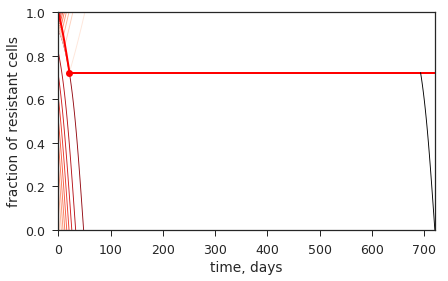

In [17]:
tmx = 720.
end_switching_curve = {'t': 24., 'x': .9/.8} 
# for Τ, Τbar in zip([28]*5,[14,21,28,35,60]):
for Τ, Τbar in zip([28],[60]):
    μ = 1./Τ; μbar = 1./Τbar
    print("Parameters: μ = %.5f, μbar = %.5f"%(μ,μbar))
    end_switching_curve['t'], end_switching_curve['x'] = fsolve(get_δρ_ending,(end_switching_curve['t'],.8*end_switching_curve['x']),args=(μ,μbar),xtol=1.0e-12)
    end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
    print("Ending point for the switching line: τ = %.1f days, x = %.1f%%" % (end_point[0], end_point[1]*100))
    print("Checking the solution - should give zero values: ")
    print(get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar))
    print("* Constructing the primary field")
    experiments = {
        'sol1': { 'T_end': tmx, 'τ0': 0., 'x0': list(np.linspace(0,end_switching_curve['x']-(1e-3),10))+list(np.linspace(end_switching_curve['x']+(1e-6),1.,10)) } }
    primary_field = []
    for name, values in experiments.items():
        primary_field.append(get_primary_field(name,values,μ,μbar))
    print("* Constructing the switching curve")
    switching_curve = []
    x0s = np.linspace(end_switching_curve['x'],1,21); _y = end_switching_curve['t']
    
    for x0 in x0s:
        tme = fsolve(get_δρ_value,_y,args=(x0,μ,μbar))[0]
        if (tme>0):
            switching_curve = switching_curve+[[tme,get_state(tme,x0,μ,μbar)[0]]]
            _y = tme
    print("* Constructing the universal curve")
    universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
    print("* Finding the last characteristic")
    #time0 = time.time()
    tuniv = fsolve(get_finalizing_point_from_universal_curve,tmx-40.,args=(tmx,end_point,μ,μbar,))[0]
    #print("The proccess to find the last characteristic took %0.1f minutes" % ((time.time()-time0)/60.))
    univ_point = get_state_universal(tuniv,end_point,μ,μbar)
    print("The last point on the universal line:")
    print(univ_point)
    last_trajectory = get_trajectory_with_σstar(univ_point,tmx,50,μ,μbar)
    print("Final state:")
    final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
    print(final_state)
    print("Fold-change in tumor size: %.2f"%(exp((b-d)*tmx-final_state[-1])))
    # Plotting
    plt.rcParams['figure.figsize'] = (6.75, 4)
    _k = 0
    for solutions in primary_field:
        for x0, entry in solutions.items():
            plt.plot(entry['τ'], entry['x'], 'k-', linewidth=.9, color=clrs[_k%palette_size])
            _k += 1
    plt.plot([x[0] for x in switching_curve],[x[1] for x in switching_curve],linewidth=2,color="red")
    plt.plot([end_point[0]],[end_point[1]],marker='o',color="red")
    plt.plot([x[0] for x in universal_curve],[x[1] for x in universal_curve],linewidth=2,color="red")
    plt.plot([x[0] for x in last_trajectory],[x[1] for x in last_trajectory],linewidth=.9,color="black")
    plt.xlim([0,tmx]); plt.ylim([0,1]);
    plt.xlabel("time, days"); plt.ylabel("fraction of resistant cells")
    plt.show()
    print()

In [34]:
import csv
from numpy.linalg import norm
File = open("../figures/draft/sensitivity_mu-low_cost.csv", 'w')
File.write("T,Tbar,mu,mubar,sw_start_x,sw_end_t,sw_end_x,univ_point_t,univ_point_x,outcome,err_sw_t,err_sw_x\n")
writer = csv.writer(File,lineterminator='\n')

tmx = 720.
# end_switching_curve0 = {'t': 43.36, 'x': .92}

end_switching_curve0 = {'t': 40.36, 'x': .92}
end_switching_curve_prev_t = end_switching_curve0['t']
tuniv = tmx-30.
Ts = np.arange(120,2,-2) #Τbars; 
Τbars = np.arange(120,2,-2) #np.arange(120,1,-1) #need to change here if more
for Τ in Ts:
    μ = 1./Τ
    end_switching_curve = deepcopy(end_switching_curve0)
    for Τbar in Τbars:
        μbar = 1./Τbar
        print("* Parameters: T = %.1f, Tbar = %.1f (μ = %.5f, μbar = %.5f)"%(Τ,Τbar,μ,μbar))
        success = False; err = 1.
        while (not success)|(norm(err)>1e-6):
            end_switching_curve = {'t': 2*end_switching_curve['t']-end_switching_curve_prev_t-.001, 
                                   'x': end_switching_curve['x']-0.002} 
            sol = root(get_δρ_ending,(end_switching_curve['t'],end_switching_curve['x']),args=(μ,μbar))
            end_switching_curve_prev_t = end_switching_curve['t']
            end_switching_curve_prev_x = end_switching_curve['x']
            end_switching_curve['t'], end_switching_curve['x'] = sol.x 
            success = sol.success
            err = get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar)
            if (not success): 
                print("! Trying again...", sol.message)
            elif (norm(err)>1e-6):
                print("! Trying again... Convergence is not sufficient")       
        else:
            end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
            print("Ending point: t = %.2f, x = %.2f%%"%(end_switching_curve['t'],100*end_switching_curve['x'])," Checking the solution:",err)
            universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
            tuniv = root(get_finalizing_point_from_universal_curve,tuniv,args=(tmx,end_point,μ,μbar)).x
            err_tuniv = get_finalizing_point_from_universal_curve(tuniv,tmx,end_point,μ,μbar)
            univ_point = get_state_universal(tuniv,end_point,μ,μbar)
            print("tuniv = %.2f"%tuniv,"xuniv = %.2f%%"%(100*univ_point[1])," Checking the solution: ",err_tuniv)
            final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
            outcome = exp((b-d)*tmx-final_state[-1])
            print("Fold-change in tumor size: %.2f"%(outcome))
            output = [Τ,Τbar,μ,μbar,end_switching_curve['x'],end_point[0],end_point[1]]+list(univ_point[0:2])+[outcome]+list(err)+[err_tuniv]
            writer.writerow(output)
        if (Τbar==Τ):
            end_switching_curve0 = deepcopy(end_switching_curve) 

File.close()

* Parameters: T = 20.0, Tbar = 120.0 (μ = 0.05000, μbar = 0.00833)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 19.60, x = 96.32%  Checking the solution: (-4.3777786148095242e-16, 6.9327689731048432e-17)
tuniv = 691.09 xuniv = 84.53%  Checking the solution:  3.8571923433e-13
Fold-change in tumor size: 44.75
* Parameters: T = 20.0, Tbar = 118.0 (μ = 0.05000, μbar = 0.00847)
! Trying again... Convergence is not sufficient
Ending point: t = 19.57, x = 96.27%  Checking the solution: (-1.9476481968021552e-13, -1.9045040956595896e-14)
tuniv = 691.23 xuniv = 84.36%  Checking the solution:  -9.30144850031e-13
Fold-change in tumor size: 44.13
* Parameters: T = 20.0, Tbar = 116.0 (μ = 0.05000, μbar = 0.00862)
Ending point: t = 19.53, x = 96.21%  Checking the solution: (-1.8173091883341014e-16, 8.7008616554231959e-17)
tuniv = 691.38 xuniv = 84.18%  Checking the solution:  2.3059332

Ending point: t = 18.15, x = 93.82%  Checking the solution: (-1.312452450438474e-07, -6.0211562048698554e-08)
tuniv = 696.00 xuniv = 77.42%  Checking the solution:  -1.12208679848e-12
Fold-change in tumor size: 23.72
* Parameters: T = 20.0, Tbar = 64.0 (μ = 0.05000, μbar = 0.01562)
Ending point: t = 18.04, x = 93.66%  Checking the solution: (-1.2942076410267031e-07, 2.537180440879123e-07)
tuniv = 695.52 xuniv = 77.84%  Checking the solution:  1.71063857524e-12
Fold-change in tumor size: 22.77
* Parameters: T = 20.0, Tbar = 62.0 (μ = 0.05000, μbar = 0.01613)
! Trying again... Convergence is not sufficient
Ending point: t = 18.01, x = 93.49%  Checking the solution: (-1.3338366854340563e-07, -4.7438086034328603e-07)
tuniv = 697.27 xuniv = 75.57%  Checking the solution:  -8.66626215235e-13
Fold-change in tumor size: 21.81
* Parameters: T = 20.0, Tbar = 60.0 (μ = 0.05000, μbar = 0.01667)
Ending point: t = 17.89, x = 93.31%  Checking the solution: (-1.1867094556527641e-07, -9.715880171824121

! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 12.20, x = 75.91%  Checking the solution: (8.2825016105552568e-15, 3.4404450242162859e-15)
tuniv = 706.67 xuniv = 50.89%  Checking the solution:  8.18511647349e-11
Fold-change in tumor size: 0.23
* Parameters: T = 20.0, Tbar = 8.0 (μ = 0.05000, μbar = 0.12500)
Ending point: t = 11.50, x = 72.64%  Checking the solution: (4.0728556052922749e-14, 8.8422415435151772e-15)
tuniv = 707.59 xuniv = 47.74%  Checking the solution:  -7.57727214307e-15
Fold-change in tumor size: 0.10
* Parameters: T = 20.0, Tbar = 6.0 (μ = 0.05000, μbar = 0.16667)
Ending point: t = 10.64, x = 68.13%  Checking the solution: (-2.072625806809534e-07, -4.3007680997808373e-07)
tuniv = 708.83 xuniv = 43.46%  Checking the solution:  4.38803160474e-12
Fold-change in tumor size: 0.03
* Parameters: T = 20.0, Tbar = 4.0

Ending point: t = 17.26, x = 94.59%  Checking the solution: (-1.1054052725620079e-07, -2.8576362452919151e-08)
tuniv = 696.50 xuniv = 79.74%  Checking the solution:  -1.39735445437e-13
Fold-change in tumor size: 29.99
* Parameters: T = 18.0, Tbar = 70.0 (μ = 0.05556, μbar = 0.01429)
Ending point: t = 17.21, x = 94.46%  Checking the solution: (-1.1378485549355412e-07, -3.1495284973016263e-07)
tuniv = 697.34 xuniv = 78.62%  Checking the solution:  1.13353770814e-13
Fold-change in tumor size: 29.01
* Parameters: T = 18.0, Tbar = 68.0 (μ = 0.05556, μbar = 0.01471)
Ending point: t = 17.12, x = 94.33%  Checking the solution: (-1.0759127243673192e-07, -6.3664573914497475e-08)
tuniv = 696.99 xuniv = 78.95%  Checking the solution:  6.72017996806e-13
Fold-change in tumor size: 27.99
* Parameters: T = 18.0, Tbar = 66.0 (μ = 0.05556, μbar = 0.01515)
Ending point: t = 17.08, x = 94.18%  Checking the solution: (-1.1161802896028294e-07, -4.9809570101824076e-07)
tuniv = 698.09 xuniv = 77.44%  Checking

! Trying again... Convergence is not sufficient
Ending point: t = 12.93, x = 82.90%  Checking the solution: (-4.5542024063602651e-14, -7.9943984550438766e-15)
tuniv = 705.32 xuniv = 59.13%  Checking the solution:  2.88657986403e-15
Fold-change in tumor size: 1.46
* Parameters: T = 18.0, Tbar = 14.0 (μ = 0.05556, μbar = 0.07143)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  i

tuniv = 695.28 xuniv = 84.86%  Checking the solution:  -7.78266340262e-13
Fold-change in tumor size: 48.05
* Parameters: T = 16.0, Tbar = 100.0 (μ = 0.06250, μbar = 0.01000)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 16.72, x = 96.22%  Checking the solution: (-5.0925684665437349e-10, 1.6925330874745093e-09)
tuniv = 695.40 xuniv = 84.68%  Checking the solution:  -9.45632461224e-14
Fold-change in tumor size: 47.25
* Parameters: T = 16.0, Tbar = 98.0 (μ = 0.06250, μbar = 0.01020)
Ending point: t = 16.68, x = 96.15%  Checking the solution: (-7.5537528354278974e-09, -8.9234317151393377e-09)
tuniv = 695.58 xuniv = 84.44%  Checking the solution:  2.67658117892e-12
Fold-change in tumor size: 46.43
* Parameters: T = 16.0, Tbar = 96.0 (μ = 0.06250, μbar = 0.01042)
Ending point: t = 16.64, x = 96.08%  Checking the solution: (-7.2166260714141395e-09, -1.6345652214044975e-09)
tuniv = 695.71 xuniv = 84.24%  Checking the solution:

Ending point: t = 14.98, x = 92.67%  Checking the solution: (-7.8673034239866175e-16, -7.2920063685811767e-16)
tuniv = 700.65 xuniv = 75.52%  Checking the solution:  -1.78031200893e-12
Fold-change in tumor size: 19.00
* Parameters: T = 16.0, Tbar = 44.0 (μ = 0.06250, μbar = 0.02273)
Ending point: t = 14.87, x = 92.40%  Checking the solution: (1.1758177431044742e-14, 9.7906696038841313e-15)
tuniv = 700.92 xuniv = 74.94%  Checking the solution:  1.33021371695e-12
Fold-change in tumor size: 17.73
* Parameters: T = 16.0, Tbar = 42.0 (μ = 0.06250, μbar = 0.02381)
Ending point: t = 14.75, x = 92.11%  Checking the solution: (-3.6379341718435244e-14, -8.1511419614676708e-17)
tuniv = 701.20 xuniv = 74.33%  Checking the solution:  -1.39860692472e-12
Fold-change in tumor size: 16.45
* Parameters: T = 16.0, Tbar = 40.0 (μ = 0.06250, μbar = 0.02500)
Ending point: t = 14.62, x = 91.79%  Checking the solution: (2.4740873971518295e-14, 6.2550096994963935e-15)
tuniv = 701.49 xuniv = 73.68%  Checking th

! Trying again... Convergence is not sufficient
Ending point: t = 8.37, x = 64.32%  Checking the solution: (-6.3465357347135634e-07, -5.679678207376514e-07)
tuniv = 711.33 xuniv = 40.92%  Checking the solution:  -2.22113993864e-13
Fold-change in tumor size: 0.01
* Parameters: T = 14.0, Tbar = 120.0 (μ = 0.07143, μbar = 0.00833)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 15.61, x = 97.05%  Checking the solution: (-1.6139422871411831e-09, -2.5315986724277295e-11)
tuniv = 695.71 xuniv = 87.58%  

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 14.68, x = 95.24%  Checking the solution: (-1.1665496642020711e-08, -6.5235020644310231e-08)
tuniv = 699.53 xuniv = 81.94%  Checking the solution:  1.77516334965e-12
Fold-change in tumor size: 38.42
* Parameters: T = 14.0, Tbar = 68.0 (μ = 0.07143, μbar = 0.01471)
Ending point: t = 14.62, x = 95.12%  Checking the solution: (-4.175854946038999e-12, -9.4905711320090667e-13)
tuniv = 699.56 xuniv = 81.79%  Checking the solution:  -8.77631300966e-14
Fold-change in tumor size: 37.24
* Parameters: T = 14.0, Tbar = 66.0 (μ = 0.07143, μbar = 0.01515)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 14.56, x = 94.99%  Checking the solution:

! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 12.21, x = 88.72%  Checking the solution: (2.1856006384595762e-14, 6.6131156317763685e-16)
tuniv = 705.31 xuniv = 68.37%  Checking the solut

! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by 

Ending point: t = 13.39, x = 95.99%  Checking the solution: (-1.9992789437705216e-08, -6.300566930093407e-08)
tuniv = 700.62 xuniv = 84.32%  Checking the solution:  -4.13558076673e-15
Fold-change in tumor size: 48.70
* Parameters: T = 12.0, Tbar = 74.0 (μ = 0.08333, μbar = 0.01351)
Ending point: t = 13.34, x = 95.89%  Checking the solution: (-1.3473067998436284e-08, -1.1899333744551552e-08)
tuniv = 700.66 xuniv = 84.20%  Checking the solution:  -2.46518083724e-13
Fold-change in tumor size: 47.52
* Parameters: T = 12.0, Tbar = 72.0 (μ = 0.08333, μbar = 0.01389)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 13.30, x = 95.79%  Checking the solution: (-4.72845584831567e-09, -3.6897790977960362e-08)
tuniv = 700.88 xuniv = 83.84%  Checking the solution:  -8.62535737278e-12
Fold-change in tumor size: 46.32
* Parameters: T = 12.0, Tbar = 70.0 (μ = 0.08333, μbar = 0.01429)
Ending point: t = 13.25, x

Ending point: t = 10.68, x = 88.17%  Checking the solution: (-4.4201535686120082e-11, -1.4037592329618436e-11)
tuniv = 707.24 xuniv = 67.86%  Checking the solution:  -1.91305304931e-14
Fold-change in tumor size: 6.39
* Parameters: T = 12.0, Tbar = 18.0 (μ = 0.08333, μbar = 0.05556)
! Trying again... Convergence is not sufficient
Ending point: t = 10.43, x = 87.24%  Checking the solution: (-5.2006381135878115e-08, 4.4380336468537736e-07)
tuniv = 707.34 xuniv = 67.12%  Checking the solution:  -2.03614902716e-13
Fold-change in tumor size: 5.00
* Parameters: T = 12.0, Tbar = 16.0 (μ = 0.08333, μbar = 0.06250)
Ending point: t = 10.16, x = 86.13%  Checking the solution: (-5.1173501879841229e-08, -7.239153848819077e-11)
tuniv = 708.13 xuniv = 64.71%  Checking the solution:  1.32376314771e-13
Fold-change in tumor size: 3.74
* Parameters: T = 12.0, Tbar = 14.0 (μ = 0.08333, μbar = 0.07143)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the la

Ending point: t = 12.02, x = 96.95%  Checking the solution: (-2.8498308441600866e-08, -4.9052006200763594e-08)
tuniv = 701.49 xuniv = 87.56%  Checking the solution:  -3.2222835511e-13
Fold-change in tumor size: 65.56
* Parameters: T = 10.0, Tbar = 88.0 (μ = 0.10000, μbar = 0.01136)
Ending point: t = 12.02, x = 96.89%  Checking the solution: (-3.2261598987633507e-08, -4.0843477671557949e-07)
tuniv = 702.53 xuniv = 86.24%  Checking the solution:  -1.51591239561e-12
Fold-change in tumor size: 64.58
* Parameters: T = 10.0, Tbar = 86.0 (μ = 0.10000, μbar = 0.01163)
Ending point: t = 11.96, x = 96.83%  Checking the solution: (-2.1302282910618915e-08, 8.0733721140237058e-08)
tuniv = 701.37 xuniv = 87.57%  Checking the solution:  -9.29376020586e-12
Fold-change in tumor size: 63.43
* Parameters: T = 10.0, Tbar = 84.0 (μ = 0.10000, μbar = 0.01190)
Ending point: t = 11.94, x = 96.76%  Checking the solution: (-1.9785393399226544e-08, -6.3909354193980902e-08)
tuniv = 701.91 xuniv = 86.90%  Checking

Fold-change in tumor size: 23.26
* Parameters: T = 10.0, Tbar = 32.0 (μ = 0.10000, μbar = 0.03125)
Ending point: t = 10.41, x = 92.62%  Checking the solution: (-7.7570074764859399e-08, 6.2262917028270859e-09)
tuniv = 706.52 xuniv = 76.48%  Checking the solution:  3.80653841781e-13
Fold-change in tumor size: 21.22
* Parameters: T = 10.0, Tbar = 30.0 (μ = 0.10000, μbar = 0.03333)
Ending point: t = 10.29, x = 92.22%  Checking the solution: (-8.9449373662619474e-08, -8.3702778084644274e-08)
tuniv = 706.90 xuniv = 75.46%  Checking the solution:  3.41116024316e-14
Fold-change in tumor size: 19.16
* Parameters: T = 10.0, Tbar = 28.0 (μ = 0.10000, μbar = 0.03571)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 10.16, x = 91.79%  Checking the solution: (-7.870130846483039e-08, -6.2260538718573647e-08)
tuniv = 707.16 xuniv = 74.63%  Checking the solution:  -2.0872192863e-14
Fold-change in tumor size: 1

Ending point: t = 10.43, x = 97.84%  Checking the solution: (-3.0822240419723454e-08, -5.7056318924504268e-07)
tuniv = 704.16 xuniv = 89.04%  Checking the solution:  -2.94347879404e-14
Fold-change in tumor size: 87.24
* Parameters: T = 8.0, Tbar = 108.0 (μ = 0.12500, μbar = 0.00926)
Ending point: t = 10.35, x = 97.81%  Checking the solution: (-1.9773293029595442e-08, 2.7303515885302192e-07)
tuniv = 701.56 xuniv = 91.71%  Checking the solution:  3.52330664644e-12
Fold-change in tumor size: 86.25
* Parameters: T = 8.0, Tbar = 106.0 (μ = 0.12500, μbar = 0.00943)
Ending point: t = 10.36, x = 97.77%  Checking the solution: (-1.807995445877809e-08, -7.4039314693876413e-08)
tuniv = 702.95 xuniv = 90.43%  Checking the solution:  -1.04374842103e-13
Fold-change in tumor size: 85.33
* Parameters: T = 8.0, Tbar = 104.0 (μ = 0.12500, μbar = 0.00962)
Ending point: t = 10.34, x = 97.73%  Checking the solution: (-1.6047015256985918e-08, 1.1249530599268068e-09)
tuniv = 702.80 xuniv = 90.54%  Checking t

Ending point: t = 9.60, x = 95.77%  Checking the solution: (3.5391804258791469e-13, 1.335467902350385e-13)
tuniv = 706.09 xuniv = 84.46%  Checking the solution:  -3.09127723419e-15
Fold-change in tumor size: 50.70
* Parameters: T = 8.0, Tbar = 50.0 (μ = 0.12500, μbar = 0.02000)
Ending point: t = 9.55, x = 95.62%  Checking the solution: (1.6972173860444622e-12, 7.2291605134333491e-13)
tuniv = 706.26 xuniv = 84.05%  Checking the solution:  -8.73303165894e-15
Fold-change in tumor size: 48.80
* Parameters: T = 8.0, Tbar = 48.0 (μ = 0.12500, μbar = 0.02083)
Ending point: t = 9.50, x = 95.47%  Checking the solution: (6.3668107185382004e-13, 2.3790947311956628e-13)
tuniv = 706.44 xuniv = 83.63%  Checking the solution:  2.28289609439e-14
Fold-change in tumor size: 46.84
* Parameters: T = 8.0, Tbar = 46.0 (μ = 0.12500, μbar = 0.02174)
Ending point: t = 9.44, x = 95.30%  Checking the solution: (-6.481986282944944e-13, -2.3009283847417108e-13)
tuniv = 706.62 xuniv = 83.17%  Checking the solution:

! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
Ending point: t = 6.16, x = 78.87%  Checking the solution: (-1.8451329160036142e-07, 1.3344951144432298e-09)
tuniv = 713.17 xuniv = 56.33%  Checking the solution:  -2.85255326304e-12
Fold-change in tumor size: 0.59
* Parameters: T = 8.0, Tbar = 4.0 (μ = 0.12500, μbar = 0.25000)
! Trying again... Convergence is not sufficient
Ending point: t = 5.51, x = 7

Ending point: t = 8.00, x = 97.38%  Checking the solution: (-2.9280315300804626e-13, -1.460015836908673e-13)
tuniv = 707.09 xuniv = 89.57%  Checking the solution:  -3.64135249731e-11
Fold-change in tumor size: 81.49
* Parameters: T = 6.0, Tbar = 68.0 (μ = 0.16667, μbar = 0.01471)
Ending point: t = 7.97, x = 97.31%  Checking the solution: (6.9079887074230388e-13, 2.9220066281143339e-12)
tuniv = 707.20 xuniv = 89.34%  Checking the solution:  -5.09314812547e-15
Fold-change in tumor size: 80.01
* Parameters: T = 6.0, Tbar = 66.0 (μ = 0.16667, μbar = 0.01515)
Ending point: t = 7.95, x = 97.24%  Checking the solution: (-8.676659547749366e-13, -3.9485639206093711e-13)
tuniv = 707.31 xuniv = 89.10%  Checking the solution:  2.86454887588e-14
Fold-change in tumor size: 78.48
* Parameters: T = 6.0, Tbar = 64.0 (μ = 0.16667, μbar = 0.01562)
Ending point: t = 7.93, x = 97.16%  Checking the solution: (-2.9059086415615248e-13, -1.3231965588136097e-13)
tuniv = 707.43 xuniv = 88.85%  Checking the solut

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 6.58, x = 91.68%  Checking the solution: (-2.8008471677176699e-08, -1.5946025642950643e-07)
tuniv = 711.75 xuniv = 75.01%  Checking the solution:  -2.88269408344e-13
Fold-change in tumor size: 18.19
* Parameters: T = 6.0, Tbar = 16.0 (μ = 0.16667, μbar = 0.06250)
! Trying again... Convergence is not sufficient
Ending point: t = 6.43, x = 90.89%  Checking the solution: (9.6014615753513505e-13, 6.5526927739429799e-13)
tuniv = 711.96 xuniv = 73.83%  Checking the solution:  -5.97091820431e-15
Fold-change in tumor size: 14.76
* Parameters: T = 6.0, Tbar = 14.0 (μ = 0.16667, μbar = 0.07143)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 6.26, x = 89.92%  Checking the solution: (-2.9744608841791865e-08, -1.4214797732980811e-08)
tuniv = 712.32 xuniv = 72.05% 

Ending point: t = 5.86, x = 98.47%  Checking the solution: (3.0134907046334004e-15, 1.7010260355746101e-14)
tuniv = 709.23 xuniv = 93.59%  Checking the solution:  -3.80020251378e-11
Fold-change in tumor size: 115.32
* Parameters: T = 4.0, Tbar = 86.0 (μ = 0.25000, μbar = 0.01163)
Ending point: t = 5.85, x = 98.44%  Checking the solution: (-4.8718189076294664e-13, -2.8824065275890297e-12)
tuniv = 709.30 xuniv = 93.46%  Checking the solution:  -4.19100101845e-11
Fold-change in tumor size: 114.31
* Parameters: T = 4.0, Tbar = 84.0 (μ = 0.25000, μbar = 0.01190)
Ending point: t = 5.84, x = 98.41%  Checking the solution: (-4.2206743742362329e-14, -2.9020525997760473e-14)
tuniv = 709.37 xuniv = 93.34%  Checking the solution:  -4.63413214052e-11
Fold-change in tumor size: 113.26
* Parameters: T = 4.0, Tbar = 82.0 (μ = 0.25000, μbar = 0.01220)
Ending point: t = 5.83, x = 98.37%  Checking the solution: (-1.5085594745435703e-14, 1.4989791032780554e-14)
tuniv = 709.45 xuniv = 93.20%  Checking the 

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 5.29, x = 95.94%  Checking the solution: (-2.8834649939181348e-08, -9.0083939173964968e-11)
tuniv = 712.24 xuniv = 85.54%  Checking the solution:  1.36002320517e-15
Fold-change in tumor size: 59.06
* Parameters: T = 4.0, Tbar = 28.0 (μ = 0.25000, μbar = 0.03571)
! Trying again... Convergence is not sufficient
Ending point: t = 5.24, x = 95.69%  Checking the solution: (-2.331765720762646e-08, -2.7187997366519528e-09)
tuniv = 712.41 xuniv = 84.85%  Checking the solution:  1.10300657497e-13
Fold-change in tumor size: 55.28
* Parameters: T = 4.0, Tbar = 26.0 (μ = 0.25000, μbar = 0.03846)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 5.19, x = 95.41%  Checking the solution: (-6.6961360607221372e-09, -3.1400346658243082e-07)
tuniv = 712.87 xuniv = 83.26%  Checking the solution:  -3.73

* Here I investigate the dependence of $\mathrm{FoldChange}(T,\bar T)$. I fix $T$ at 15,30,45,60 days, and then I vary $\bar T$ between zero and $4T$. The example below is just a simulation for only one given value of $T$.  

In [ ]:
import csv
from numpy.linalg import norm
File = open("../results/sensitivity1.csv", 'w')
File.write("T,Tbar,mu,mubar,sw_end_t,sw_end_x,univ_point_t,univ_point_x,outcome,err_sw_t,err_sw_x\n")
writer = csv.writer(File,lineterminator='\n')

tmx = 720.
end_switching_curve = {'t': 23.36, 'x': .9592}
end_switching_curve_prev_t = end_switching_curve['t']
tuniv = tmx-30.
Τ = 15
Τbars_step = .5; Tbars = np.arange(Τ*4,0,-Τbars_step)
for Τbar in Tbars:
    μ = 1./Τ; μbar = 1./Τbar
    print("* Parameters: T = %.1f, Tbar = %.1f (μ = %.5f, μbar = %.5f)"%(Τ,Τbar,μ,μbar))
    success = False; err = 1.
    while (not success)|(norm(err)>1e-6):
        end_switching_curve = {'t': 2*end_switching_curve['t']-end_switching_curve_prev_t-.001, 
                               'x': end_switching_curve['x']-0.002} 
        sol = root(get_δρ_ending,(end_switching_curve['t'],end_switching_curve['x']),args=(μ,μbar))
        end_switching_curve_prev_t = end_switching_curve['t']
        end_switching_curve_prev_x = end_switching_curve['x']
        end_switching_curve['t'], end_switching_curve['x'] = sol.x   
        success = sol.success
        err = get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar)
        if (not success): 
            print("! Trying again...", sol.message)
        elif (norm(err)>1e-6):
            print("! Trying again... Convergence is not sufficient")       
    else:
        end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
        print("Ending point: t = %.2f, x = %.2f%%"%(end_switching_curve['t'],100*end_switching_curve['x'])," Checking the solution:",err)
        universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
        tuniv = root(get_finalizing_point_from_universal_curve,tuniv,args=(tmx,end_point,μ,μbar)).x
        err_tuniv = get_finalizing_point_from_universal_curve(tuniv,tmx,end_point,μ,μbar)
        univ_point = get_state_universal(tuniv,end_point,μ,μbar)
        print("tuniv = %.2f"%tuniv," Checking the solution: ",err_tuniv)
        final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
        outcome = exp((b-d)*tmx-final_state[-1])
        print("Fold-change in tumor size: %.2f"%(outcome))
        output = [Τ,Τbar,μ,μbar,end_switching_curve['t'],end_switching_curve['x']]+list(univ_point[0:2])+[outcome]+list(err)+[err_tuniv]
        writer.writerow(output)
    
File.close()

* The results are aggregated in a file **sensitivity1_agg.csv**.

In [419]:
df = pd.DataFrame.from_csv("../figures/draft/sensitivity1_agg.csv").reset_index().drop(['err_sw_t','err_sw_x','err_tuniv'],1)
df['Tratio'] = df['Tbar']/df['T']
df.head()

,T,Tbar,mu,mubar,sw_end_t,sw_end_x,univ_point_t,univ_point_x,outcome,Tratio
0,45,180.0,0.022222,0.005556,29.936471,0.965414,667.300425,0.859250,4.737060,4.000000
1,45,179.0,0.022222,0.005587,29.925299,0.965235,667.383412,0.858656,4.718207,3.977778
2,45,178.0,0.022222,0.005618,29.914016,0.965055,667.466799,0.858057,4.699231,3.955556
3,45,177.0,0.022222,0.005650,29.902622,0.964873,667.550603,0.857452,4.680132,3.933333
4,45,176.0,0.022222,0.005682,29.891112,0.964689,667.634783,0.856842,4.660908,3.911111
